## Task 1: Feature Extraction Using Autoencoder for Classification 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
## Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Normalize in range [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

## Adding a channel dimension....since greyscale adding 1 dim across last axis
x_train = np.expand_dims(x_train, axis=-1)  
x_test = np.expand_dims(x_test, axis=-1)   

print(f"Training shape: {x_train.shape}")
print(f"Testing shape: {x_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Testing data shape: (10000, 28, 28, 1)


#### Setting up a convolutional autoencoder

In [3]:
def encoder_setup(input_shape, latent_dim):
    encoder_input = Input(shape=input_shape, name="encoder_input") ## match with mnist ip
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input) ## 32 filter...3x3 kernel
    x = MaxPooling2D((2, 2), padding='same')(x) ## stride defaulted to (3,3) 
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) ## 16 filter...3x3 kernel
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x) ## 3D->1D
    encoder_output = Dense(latent_dim, activation='relu', name="latent_space")(x) ## compress flatened op to lower dimensional latent space
    return Model(encoder_input, encoder_output, name="Encoder")

def decoder_setup(latent_dim, output_shape):
    decoder_input = Input(shape=(latent_dim,), name="decoder_input") ## match with the size of latent space
    x = Dense(output_shape[0] * output_shape[1] * output_shape[2], activation='relu')(decoder_input) ## re-expand latent vector to a flattened form 
    x = Reshape(output_shape)(x) ## 1D->3D
    x = UpSampling2D((2, 2))(x) ## double x,y
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) ## convert to 16 filter form
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) ## convert to 32 filter form
    decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="reconstructed_output")(x) ## reduce to 1 filter
    return Model(decoder_input, decoder_output, name="Decoder")

def autoencoder_setup(input_shape, latent_dim):
    encoder = encoder_setup(input_shape, latent_dim)
    print("encoder setup")
    encoder.summary()
    decoder = decoder_setup(latent_dim, (7, 7, 64)) ## capture more detailed features
    print("decoder setup")
    decoder.summary()
    autoencoder_input = encoder.input
    autoencoder_output = decoder(encoder(autoencoder_input))
    autoencoder = Model(autoencoder_input, autoencoder_output, name="Autoencoder")
    autoencoder.compile(optimizer='adam', loss='mse')
    return encoder, decoder,autoencoder

In [4]:
input_shape = (28, 28, 1)
latent_dim = 128
encoder, decoder,autoencoder = autoencoder_setup(input_shape, latent_dim)
autoencoder.summary()

encoder setup


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 128)                 │         100,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,424 (411.81 KB)

 Trainable params: 105,424 (411.81 KB)

 Non-trainable params: 0 (0.00 B)

decoder setup


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3136)                │         404,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstructed_output (Conv2D)        │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,705 (1.60 MB)

 Trainable params: 418,705 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ (None, 128)                 │         105,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 28, 28, 1)           │         418,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 524,129 (2.00 MB)

 Trainable params: 524,129 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def train_autoencoder(autoencoder, x_train, epochs=50, batch_size=256, validation_split=0.2):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = autoencoder.fit(
        x_train, x_train,  
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_split=validation_split,
        callbacks=[early_stopping]
    )
    return history

In [6]:
history_autoenc = train_autoencoder(autoencoder, x_train)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 0.0830 - val_loss: 0.0151
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0128 - val_loss: 0.0088
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━

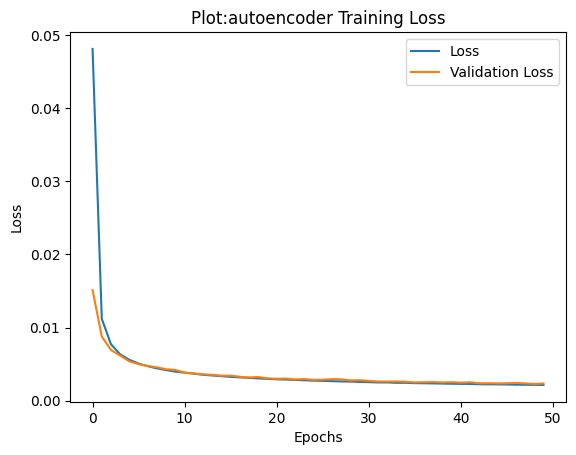

In [7]:
plt.plot(history_autoenc.history['loss'], label='Loss')
plt.plot(history_autoenc.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Plot:autoencoder Training Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


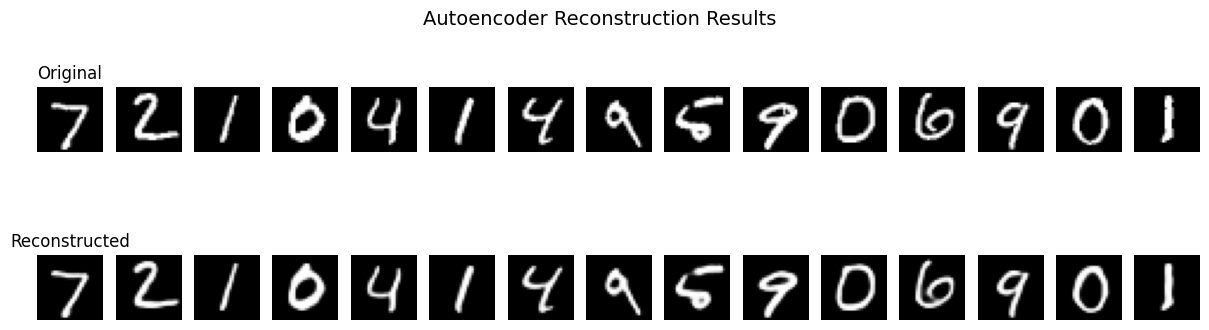

In [8]:
## Get reconstructed images from the autoencoder
reconstructed_images = autoencoder.predict(x_test[:15])

## Plot original vs. reconstructed images
fig, axes = plt.subplots(2, 15, figsize=(15, 4))

for i in range(15):
    ## Original Image
    axes[0, i].imshow(x_test[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    
    ## Reconstructed Image
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original", fontsize=12)
axes[1, 0].set_title("Reconstructed", fontsize=12)

plt.suptitle("Autoencoder Reconstruction Results", fontsize=14)
plt.show()

In [9]:
def classifier_setup(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [10]:
def train_classifier(classifier, x_train, y_train, epochs=50, batch_size=128, validation_split=0.2):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.001, restore_best_weights=True)
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = classifier.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping]
    )
    return history

In [11]:
## Flatten images for classifier 
x_train_flat = x_train.reshape(x_train.shape[0], -1) ## (6k,28,28) -> (6k,784)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

## Train Classifier
classifier = classifier_setup(28 * 28, 10)
history_classifier = train_classifier(classifier, x_train_flat, y_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8125 - loss: 0.6749 - val_accuracy: 0.9437 - val_loss: 0.1868
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9527 - loss: 0.1613 - val_accuracy: 0.9611 - val_loss: 0.1302
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9686 - loss: 0.1078 - val_accuracy: 0.9642 - val_loss: 0.1180
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9757 - loss: 0.0825 - val_accuracy: 0.9716 - val_loss: 0.0975
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9811 - loss: 0.0626 - val_accuracy: 0.9720 - val_loss: 0.0898
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9850 - loss: 0.0500 - val_accuracy: 0.9734 - val_loss: 0.0915
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9880 - loss: 0.0413 - val_accuracy: 0.9734 - val_loss: 0.0898
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9911 - loss: 0.0303 - val_accuracy: 0.

In [13]:
def encode_data(encoder, x_train, x_test):
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    print(f"Encoded train shape: {encoded_train.shape}")
    print(f"Encoded test shape: {encoded_test.shape}")
    return encoded_train, encoded_test
    
## Encode Data
encoded_train, encoded_test = encode_data(encoder, x_train, x_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Encoded train shape: (60000, 128)
Encoded test shape: (10000, 128)


In [12]:
def build_pretrained_classifier(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:

classifier_pretrained = build_pretrained_classifier(128, 10)
history_pretrained = train_classifier(classifier_pretrained, encoded_train, y_train)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5123 - loss: 1.5075 - val_accuracy: 0.9032 - val_loss: 0.3457
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9024 - loss: 0.3344 - val_accuracy: 0.9307 - val_loss: 0.2405
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9235 - loss: 0.2562 - val_accuracy: 0.9383 - val_loss: 0.2070
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9391 - loss: 0.2075 - val_accuracy: 0.9484 - val_loss: 0.1791
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9460 - loss: 0.1815 - val_accuracy: 0.9515 - val_loss: 0.1645
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9520 - loss: 0.1616 - val_accuracy: 0.9566 - val_loss: 0.1489
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9562 - loss: 0.1485 - val_accuracy: 0.9582 - val_loss: 0.1453
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9579 - loss: 0.1448 - val_accuracy: 0.

In [15]:
## Evaluate classifier without pretraining
loss_s_class, acc_s_class = classifier.evaluate(x_test_flat, y_test, verbose=0)

## Evaluate classifier with pretraining
loss_pretrained, acc_pretrained = classifier_pretrained.evaluate(encoded_test, y_test, verbose=0)

## Print Accuracy Comparison
print(f"Accuracy without Pretraining: {acc_s_class * 100:.2f}%")
print(f"Accuracy with Pretraining: {acc_pretrained * 100:.2f}%")


Accuracy without Pretraining: 97.45%
Accuracy with Pretraining: 97.14%


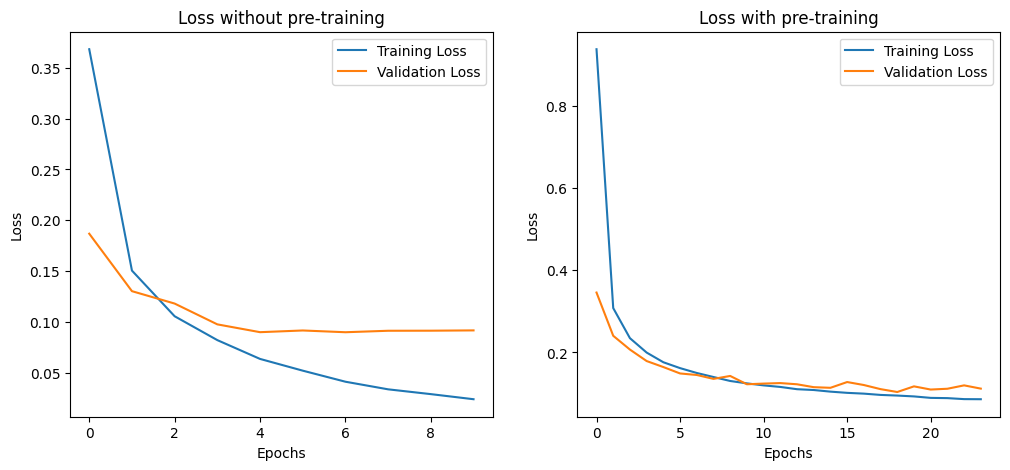

In [16]:
plt.figure(figsize=(12, 5))

## Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label="Training Loss")
plt.plot(history_classifier.history['val_loss'], label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss without pre-training")

plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['loss'], label="Training Loss")
plt.plot(history_pretrained.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss with pre-training")
plt.show()

####  Inference: 
- Without pre-training: Even though training loss starts low, validation data plateaus quickly, but training loss keeps decreasing. This shows that the model is overfitting on training data by memorising the training data instead of generalising
- With pre-training on encoder: Validation loss doesn't plateau but follows training loss closely indicating low overfitting on training data

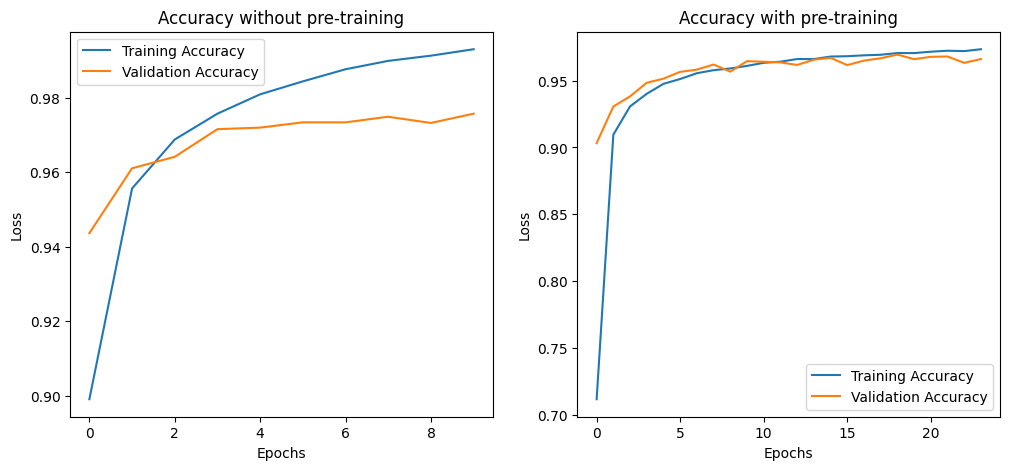

In [17]:
plt.figure(figsize=(12, 5))

## Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['accuracy'], label="Training Accuracy")
plt.plot(history_classifier.history['val_accuracy'], label="Validation Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Accuracy without pre-training")

plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['accuracy'], label="Training Accuracy")
plt.plot(history_pretrained.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Accuracy with pre-training")
plt.show()

####  Inference: 
- Without pre-training: Validation accuracy stops improving indicating that the model is overfitting on the training data, indicating failure to generalise.
- With pre-training on encoder: The validation accuracy closely follows the training accuracy, showing the model is not overfitting.

### Testing pre-trained classifier(trained on mnist) for Fashion-MNIST data

In [18]:
from tensorflow.keras.datasets import fashion_mnist

## Load Fashion-MNIST data
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()

## Normalize images to [0,1] range
x_train_fashion = x_train_fashion.astype("float32") / 255.0
x_test_fashion = x_test_fashion.astype("float32") / 255.0

## Reshape to make it compatible with the autoencoder
x_train_fashion = x_train_fashion.reshape(-1, 28, 28, 1)
x_test_fashion = x_test_fashion.reshape(-1, 28, 28, 1)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
x_train_fashion.shape

(60000, 28, 28, 1)

In [19]:
encoded_train_fashion, encoded_test_fashion = encode_data(encoder, x_train_fashion, x_test_fashion)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Encoded train shape: (60000, 128)
Encoded test shape: (10000, 128)


In [20]:
## Testing MNIST data before being fine tuned on pretrained classifier 
loss_fashion, acc_fashion = classifier_pretrained.evaluate(encoded_test_fashion, y_test_fashion, verbose=0)
print(f"Accuracy before fine-tuning on Fashion-MNIST: {acc_fashion * 100:.2f}")

Accuracy before fine-tuning on Fashion-MNIST: 7.56


In [21]:
history_finetune = train_classifier(classifier_pretrained, encoded_train_fashion, y_train_fashion)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4972 - loss: 2.1219 - val_accuracy: 0.7498 - val_loss: 0.7082
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7597 - loss: 0.6637 - val_accuracy: 0.7906 - val_loss: 0.5809
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8025 - loss: 0.5545 - val_accuracy: 0.8173 - val_loss: 0.5139
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8202 - loss: 0.5006 - val_accuracy: 0.8274 - val_loss: 0.4850
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8331 - loss: 0.4691 - val_accuracy: 0.8298 - val_loss: 0.4813
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8415 - loss: 0.4490 - val_accuracy: 0.8320 - val_loss: 0.4669
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8428 - loss: 0.4405 - val_accuracy: 0.8216 - val_loss: 0.4834
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8493 - loss: 0.4254 - val_accuracy: 0.

In [22]:
## Testing MNIST data after being fine tuned on pretrained classifier 
loss_fashion, acc_fashion = classifier_pretrained.evaluate(encoded_test_fashion, y_test_fashion, verbose=0)
print(f"Accuracy after fine-tuning on Fashion-MNIST: {acc_fashion* 100:.2f}")

Accuracy after fine-tuning on Fashion-MNIST: 86.53


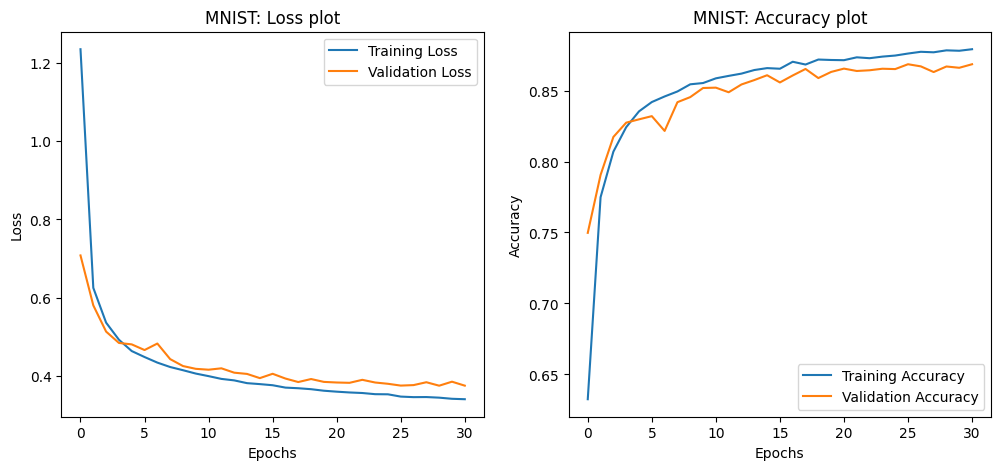

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MNIST: Loss plot')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST: Accuracy plot')
plt.legend()

plt.show()

####  Inference: 
-  Validation loss doesn't plateau but follows training loss closely indicating low overfitting on training data
-  The validation accuracy closely follows the training accuracy, showing the model is not overfitting and generalising well

## Task 2 : Denoising Autoencoder for Robust Feature Learning

In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

Training data shape: (60000, 28, 28, 1)
Testing data shape: (10000, 28, 28, 1)


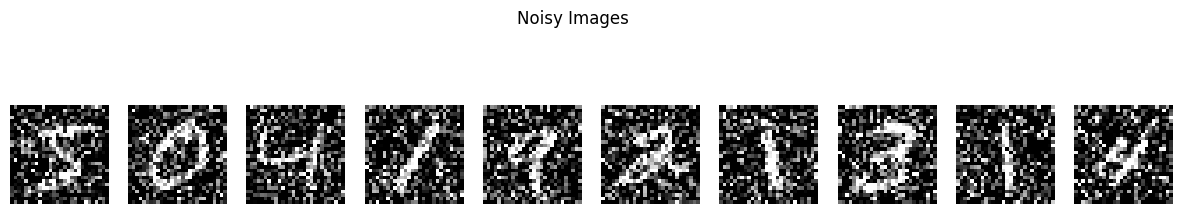

In [42]:
noise_factor = 0.5 ## gaussian noise factor

x_train_noisy = x_train + noise_factor * np.random.normal(0.0, 1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(0.0, 1.0, size=x_test.shape)

## ensure values remain between 0-1 to prevent distortion
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0) 
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

plt.figure(figsize=(15, 3))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.suptitle("Noisy Images")
plt.show()

In [26]:
input_shape = (28, 28, 1)
latent_dim = 128
encoder, decoder,autoencoder = autoencoder_setup(input_shape, latent_dim)
autoencoder.summary()

encoder setup


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 128)                 │         100,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,424 (411.81 KB)

 Trainable params: 105,424 (411.81 KB)

 Non-trainable params: 0 (0.00 B)

decoder setup


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3136)                │         404,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstructed_output (Conv2D)        │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,705 (1.60 MB)

 Trainable params: 418,705 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ (None, 128)                 │         105,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 28, 28, 1)           │         418,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 524,129 (2.00 MB)

 Trainable params: 524,129 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_autoenc = train_autoencoder(autoencoder, x_train_noisy)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.1138 - val_loss: 0.0925
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0895 - val_loss: 0.0845
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0834 - val_loss: 0.0817
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0811 - val_loss: 0.0802
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0799 - val_loss: 0.0792
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0789 - val_loss: 0.0785
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0783 - val_loss: 0.0781
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0778 - val_loss: 0.0775
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0774 - val_loss: 0.0773
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0770 - val_loss: 0.0769
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0767 - val_loss: 0.0767
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 

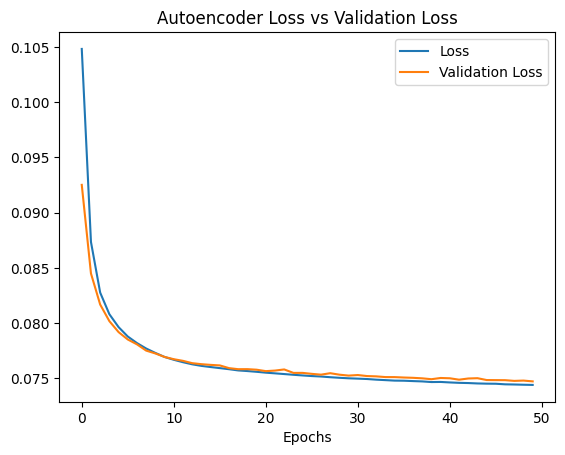

In [28]:
plt.plot(history_autoenc.history['loss'], label='Loss')
plt.plot(history_autoenc.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [29]:
encoded_train = encoder.predict(x_train_noisy)
encoded_test = encoder.predict(x_test_noisy)

print(f"Encoded Train Shape: {encoded_train.shape}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Encoded Train Shape: (60000, 128)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


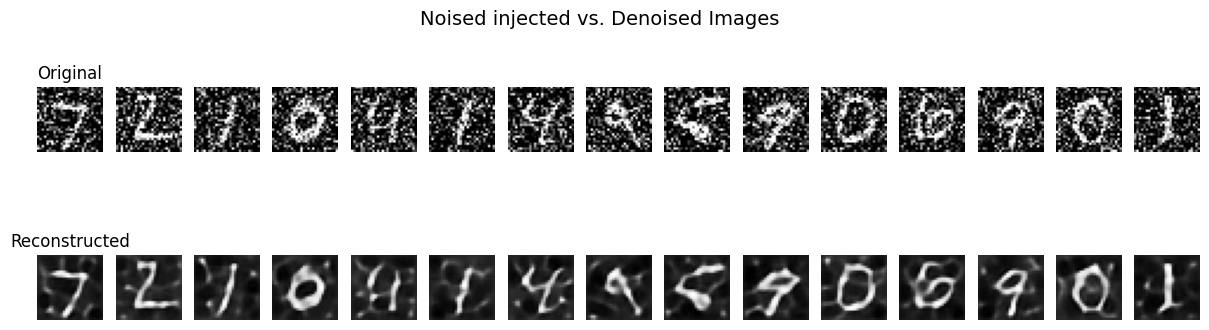

In [32]:
## Get reconstructed images from the autoencoder
reconstructed_images = autoencoder.predict(x_test_noisy[:15])

## Plot original vs. reconstructed images
fig, axes = plt.subplots(2, 15, figsize=(15, 4))

for i in range(15):
    ## Original Image
    axes[0, i].imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    
    ## Reconstructed Image
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Noise Injected images", fontsize=12)
axes[1, 0].set_title("Reconstructed", fontsize=12)

plt.suptitle("Noised injected vs. Denoised Images", fontsize=14)
plt.show()

In [33]:
## Flatten images for classifier training
x_train_flat = x_train_noisy.reshape(x_train.shape[0], -1)
x_test_flat = x_test_noisy.reshape(x_test.shape[0], -1)

## Train Classifier
classifier = classifier_setup(28 * 28, 10)
history_classifier = train_classifier(classifier, x_train_flat, y_train)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6452 - loss: 1.1178 - val_accuracy: 0.8364 - val_loss: 0.5278
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8549 - loss: 0.4664 - val_accuracy: 0.8641 - val_loss: 0.4285
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8852 - loss: 0.3654 - val_accuracy: 0.8737 - val_loss: 0.3918
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9110 - loss: 0.2897 - val_accuracy: 0.8858 - val_loss: 0.3573
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9289 - loss: 0.2289 - val_accuracy: 0.8922 - val_loss: 0.3401
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9439 - loss: 0.1861 - val_accuracy: 0.8976 - val_loss: 0.3232
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9577 - loss: 0.1432 - val_accuracy: 0.8950 - val_loss: 0.3451
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9659 - loss: 0.1192 - val_accuracy: 0.

In [35]:
## Encode Data
encoded_train, encoded_test = encode_data(encoder, x_train_noisy, x_test_noisy)
classifier_pretrained = build_pretrained_classifier(128, 10)
history_pretrained = train_classifier(classifier_pretrained, encoded_train, y_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Encoded train shape: (60000, 128)
Encoded test shape: (10000, 128)
Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3536 - loss: 1.8768 - val_accuracy: 0.7690 - val_loss: 0.7533
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7749 - loss: 0.7247 - val_accuracy: 0.8242 - val_loss: 0.5538
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8222 - loss: 0.5661 - val_accuracy: 0.8448 - val_loss: 0.4882
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8362 - loss: 0.5155 - val_accuracy: 0.8496 - val_loss: 0.4664
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8458 - loss: 0.4848 - val_accuracy: 0.8572 - val_loss: 0.4442
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8540 - loss: 0.4666 - val_accuracy: 0.8630 - val_loss: 0.4248
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8566 - loss: 0.

In [36]:
## Evaluate classifier without pretraining
loss_s_class, acc_s_class = classifier.evaluate(x_test_flat, y_test, verbose=0)

## Evaluate classifier with pretraining
loss_pretrained, acc_pretrained = classifier_pretrained.evaluate(encoded_test, y_test, verbose=0)

## Print Accuracy Comparison
print(f"Accuracy without Pretraining: {acc_s_class * 100:.2f}%")
print(f"Accuracy with Pretraining: {acc_pretrained * 100:.2f}%")


Accuracy without Pretraining: 89.82%
Accuracy with Pretraining: 91.26%


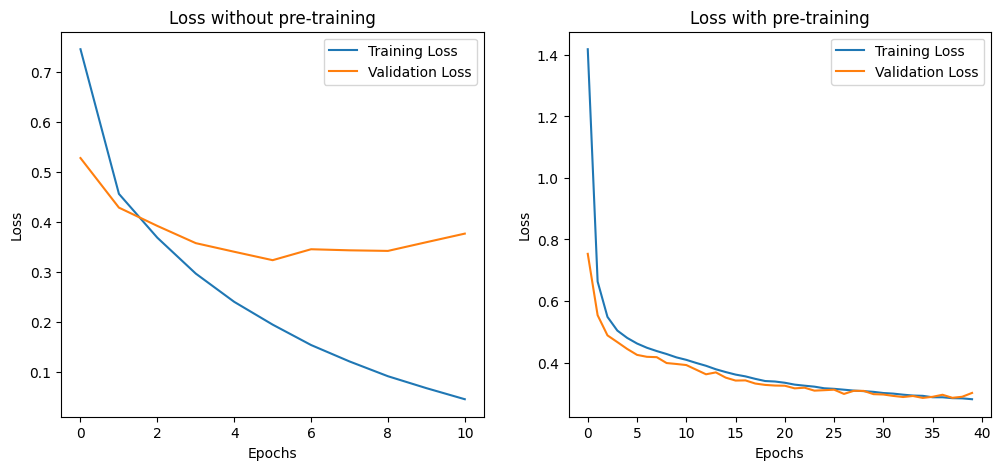

In [37]:
plt.figure(figsize=(12, 5))

## Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label="Training Loss")
plt.plot(history_classifier.history['val_loss'], label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss without pre-training")

plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['loss'], label="Training Loss")
plt.plot(history_pretrained.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss with pre-training")
plt.show()

####  Inference: 
- Without pre-training: Even though training loss starts low, validation data plateaus quickly and then starts increasing, but training loss keeps decreasing. This shows that the model is overfitting on training data by memorising the training data instead of generalising
- With pre-training on encoder: Validation loss doesn't plateau but follows training loss closely indicating low overfitting on training data

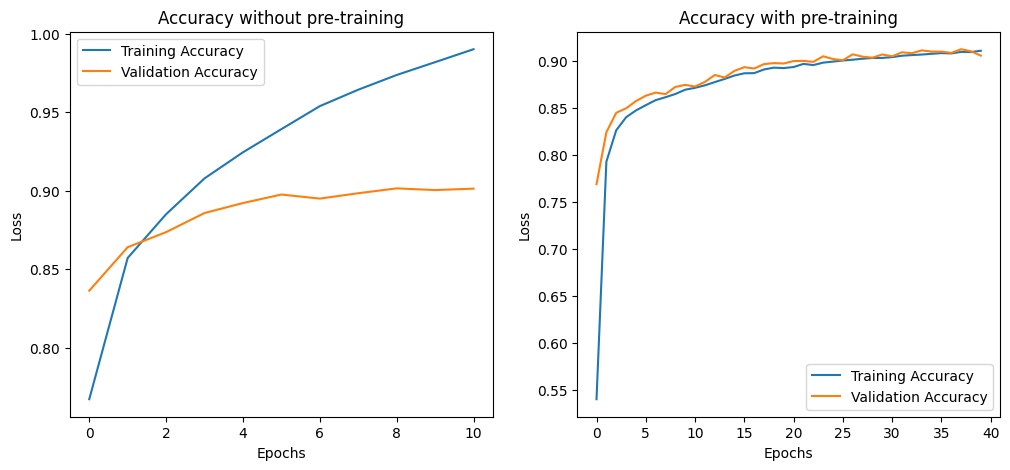

In [38]:
plt.figure(figsize=(12, 5))

## Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['accuracy'], label="Training Accuracy")
plt.plot(history_classifier.history['val_accuracy'], label="Validation Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Accuracy without pre-training")

plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['accuracy'], label="Training Accuracy")
plt.plot(history_pretrained.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Accuracy with pre-training")
plt.show()

####  Inference: 
- Without pre-training: Validation accuracy stops improving indicating that the model is overfitting on the training data, indicating failure to generalise.
- With pre-training on encoder: The validation accuracy closely follows the training accuracy, showing the model is not overfitting.